# Uterine fibroids follow-up treatment meta-analysis

Our goal is to estimate the probabilities of requiring one of a suite of candidate follow-up treatments following randomization to a given initial treatment for uterine fibroids. Specifically, we are interested in estimating:

$$Pr(I_2|I_1 =i,T=t)$$

where $I_1$ is an initial intervention, which take specific values $i = 1, 2, \ldots , K$ for each of $K$ candidate intervention types, $I_2$ is the followup intervention that also may take any of the same values of $i$, and $T$ is followup time in months, which will generally be either 6 or 12 months.

Our current set of candidate interventions include:

- Myomectomy
- Hysterectomy
- Ablation
- UAE
- Magnetic resonance imaging-guided high-intensity focused ultrasound (MRIgFUS) 
- Ablation +/- hysteroscopic myomectomy
- No intervention

Rather than model each conditional probability independently, we will instead model the outcomes for a treatment arm as a multinomial random variable. That is,

$$\{X_{I_2} \} ∼ \text{Multinomial}(N_{I_1}=i, \{\pi_i\})$$

where $\{X_{I_2}\}$ is the vector of outcomes corresponding to each of the possible followup interventions listed above, $N_{I_1}=i$ is the number of women randomized to the initial intervention i, and $\{\pi_i\}$ is a vector of conditional transition probabilities corresponding to $Pr(I_2|I_1 = i, T = t)$, as specified above. The multinomial distribution is a multivariate generalization of the categorical distribution, which is what the above simplifies to when modeling the outcome for a single patient. The multivariate formulation allows us to model study-arm-specific outcomes, incorporating covariates that are specific to that arm or study.
       
The quantities of interest are the vectors of transition probabilities $\{\pi_i\}$ corresponding to each of the initial candidate interventions. A naive approach to modeling these is to assign a vague Dirichlet prior distribution to each set, and perform Bayesian inference using the multinomial likelihood, with which the Dirichlet is conjugate, to yield posterior estimates for each probability. However, there may be additional information with which to model these probabilities, which may include:

- followup time for each study
- arm-specific demographic covariates (e.g. race, mean age) 
- study-specific random effects

hence, a given transition probability $\pi_{ijk}$ – the probability of transitioning from initial intervention $i$ to followup intervention $j$ in study $k$ – may be modeled as:

$$\text{logit}(\pi_{ijk})= \theta_{ij} + X_k \beta_{ij} + \epsilon_k$$

where $\theta_{ij}$ is a baseline transition probability (on the logit scale), $X_k$ a matrix of study(-arm)-specific covariates, $\beta_{ij}$ the corresponding coefficients, and $\epsilon_k$ a mean-zero random effect for study k. We will initially consider (1) follow-up time and (2) mean/median age as covariates.
 
An attractive benefit to using Bayesian inference to estimate this model is that it is easy to generate predictions from the model, via the posterior predictive distribution. For example, we could estimate the distribution of the expected proportion of women requiring a particular followup intervention; this estimate would factor in both the residual uncertainty in the transition probability estimates, as well as the sampling uncertainty of the intervention.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set()

Couldn't import dot_parser, loading of dot files will not be possible.


## Data Preparation

Import data from worksheets in Excel spreadsheet.

In [2]:
data_file = 'UF Subsequent Interventions Data_Master_updated.xlsx'

In [3]:
missing = ['NA', 'NR', 'ND', '?', 'null']

misc_data = pd.read_excel('data/' + data_file, sheetname='MISC (SP)', na_values=missing)
misc_data = misc_data[~misc_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = misc_data.shape
print('Occlusion rows={0}, columns={1}, missing={2}'.format(rows, cols,
                                                        misc_data.isnull().sum().sum()))

med_vs_iac_data = pd.read_excel('data/' + data_file, sheetname='Med vs IAC JW', na_values=missing)
med_vs_iac_data = med_vs_iac_data[~med_vs_iac_data['trial_arm'].isnull()].drop('notes', axis=1)
rows, cols = med_vs_iac_data.shape
print('Med vs IAC rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            med_vs_iac_data.isnull().sum().sum()))

med_vs_med_data = pd.read_excel('data/' + data_file, sheetname='Med vs Med DVE', na_values=missing)
med_vs_med_data = med_vs_med_data[~med_vs_med_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = med_vs_med_data.shape
print('Med vs Med rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            med_vs_med_data.isnull().sum().sum()))

uae_data = pd.read_excel('data/' + data_file, sheetname='UAE SK')
uae_data = uae_data[~uae_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = uae_data.shape
print('UAE rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            uae_data.isnull().sum().sum()))

datasets = [misc_data, med_vs_iac_data, med_vs_med_data, uae_data]

Occlusion rows=31, columns=13, missing=6
Med vs IAC rows=49, columns=13, missing=46
Med vs Med rows=67, columns=13, missing=13
UAE rows=32, columns=13, missing=0


In [4]:
unique_inerventions = set(np.concatenate([d.intervention.values for d in datasets]))

Use the following lookup table to create "intervention category" field in each dataset.

In [5]:
# %load intervention_lookup.py
intervention_lookup = {'Ablation': 'ablation',
 'Ablation+/- hysteroscopic myomectomy': 'ablation',
 'Asoprisnil 10 mg': 'med_manage',
 'Asoprisnil 25 mg': 'med_manage',
 'Asoprisnil 5 mg': 'med_manage',
 'Ulipristal (CD20)': 'med_manage',
 'Ulipristal (CDB10)': 'med_manage',
 'Hysterectomy': 'hysterectomy',
 'LBCUV': 'uae',
 'LP + GnRH agonist plus raloxifene': 'med_manage',
 'LP + placebo': 'med_manage',
 'LPA+ MPA / LPA+placebo': 'med_manage',
 'LPA+ placebo / LPA+MPA': 'med_manage',
 'LUNA plus LBCUV': 'ablation',
 'Myomectomy': 'myomectomy',
 'No treatment': 'control',
 'No treatment (control)': 'control',
 'Placebo': 'control',
 'Raloxifene, 180mg/day': 'med_manage',
 'SC implant of 3.6 goserelin + placebo (3 months) then tibolone 2.5 mg daily (3 months)': 'med_manage',
 'SC implant of 3.6 goserelin + placebo (6 months)': 'med_manage',
 'SC implant of 3.6 goserelin + tibolone 2.5 mg daily (6 months)': 'med_manage',
 'Surgery': 'DROP',
 'Tibolone': 'med_manage',
 'UAE': 'uae',
 'UAE only': 'uae',
 'UAE plus goserelin acetate depot': 'uae',
 'buserelin + goserelin': 'med_manage',
 'buserelin, intranasal': 'med_manage',
 'cabergoline': 'med_manage',
 'diphereline': 'med_manage',
 'gestrinone, 2.5mg': 'med_manage',
 'gestrinone, 2.5mg oral + gestrinone, 5mg oral + gestrinone, 5mg vaginal': 'med_manage',
 'gestrinone, 5mg': 'med_manage',
 'gestrinone, 5mg vaginal': 'med_manage',
 'goserelin, subcutaneous': 'med_manage',
 'healthy controls': 'control',
 'hormone replacement therapy, transdermal': 'DROP',
 'hysterectomy or myomectomy': 'DROP',
 'letrozole, 2.5mg': 'med_manage',
 'leuprolide': 'med_manage',
 'leuprolide acetate depot (11.25 mg q 3 months) + Placebo': 'med_manage',
 'leuprolide acetate depot (11.25 mg q 3 months) + tibolone 2.5 mg/d orally': 'med_manage',
 'leuprolide acetate depot (3.75 mg/28 d) + placebo (B)': 'med_manage',
 'leuprolide plus (tibolone 2.5 mg daily) (A)': 'med_manage',
 'leuprolide plus MPA': 'med_manage',
 'leuprolide plus estrogen-progestin': 'med_manage',
 'leuprolide plus placebo': 'med_manage',
 'leuprolide plus progestin': 'med_manage',
 'leuprolide plus raloxifene 60 mg daily': 'med_manage',
 'leuprolide, 1.88mg': 'med_manage',
 'leuprolide, 3.75mg': 'med_manage',
 'mifepristone, 10mg': 'med_manage',
 'mifepristone, 10mg + mifepristone, 5mg': 'med_manage',
 'mifepristone, 2.5mg': 'med_manage',
 'mifepristone, 5mg': 'med_manage',
 'placebo': 'control',
 'raloxifene 180 mg daily': 'med_manage',
 'raloxifene 60 mg daily': 'med_manage',
 'tamoxifen 20 mg daily': 'med_manage',
 'tibolone': 'med_manage',
 'tibolone, 2.5mg': 'med_manage',
 'transdermal estrogen replacement therapy': 'med_manage',
 'triptorelin, 100ug': 'med_manage',
 'triptorelin, 100ug + triptorelin, 20ug + triptorelin, 5ug': 'med_manage',
 'triptorelin, 20ug': 'med_manage',
 'triptorelin, 3.6mg/mo': 'med_manage',
 'triptorelin, 5ug': 'med_manage',
 'ulipristal acetate followed by placebo': 'med_manage',
 'ulipristal acetate followed by progestin': 'med_manage',
 'ulipristal, 10mg': 'med_manage',
 'ulipristal, 5mg': 'med_manage',
 'HIFU': 'MRgFUS',
 'HIFU with CEUS': 'MRgFUS',
 'LUAO': 'uae',
 'UAE plus PVA': 'uae',
 'UAE plus TAG': 'uae',
 'UAE with PVA': 'uae',
 'UAE with PVA particles, large': 'uae',
 'UAE with PVA particles, small': 'uae',
 'UAE with SPA': 'uae',
 'UAE with SPVA': 'uae',
 'UAE with TAG': 'uae',
 'UAE with TAG microspheres': 'uae',
 'myomectomy': 'myomectomy',
 'myomectomy with vasopressin': 'myomectomy',
 'myomectomy, abdominal': 'myomectomy',
 'myomectomy, laparoscopic': 'myomectomy',
 'myomectomy, loop ligation with vasopressin': 'myomectomy',
 'myomectomy, minilaparotomic': 'myomectomy'}


Assign intervention **categories** to each arm

In [6]:
datasets = [d.assign(intervention_cat=d.intervention.replace(intervention_lookup)) for d in datasets]

In [7]:
intervention_categories = set(intervention_lookup.values())
intervention_categories

{'DROP',
 'MRgFUS',
 'ablation',
 'control',
 'hysterectomy',
 'med_manage',
 'myomectomy',
 'uae'}

Import demographic information

In [8]:
demographics = pd.read_excel('data/' + data_file, sheetname='ALL_DEMO_DATA', na_values=missing)
demographics.columns

Index(['study_id', 'Citation', 'FamCode', 'FamDesig', 'NCT', 'ArmsN',
       'ArmCategory', 'Group_Desc', 'New Grouping', 'Demo_Category',
       'Demo_specify', 'BL N', 'Denom_N', 'BL %', 'BL Mean', 'BL SD', 'BL_SE',
       'BL_Median', 'BL Min', 'BL Max', 'BL 95% L', 'BL 95% H',
       'BL_group_diff', 'Comments'],
      dtype='object')

Extract columns of interest

In [9]:
age_data = demographics.loc[demographics.Demo_Category=='Age', ['study_id', 'New Grouping', 'BL Mean', 'BL SD']]

Clean arm labels

In [10]:
age_data = age_data.assign(arm=age_data['New Grouping'].str.replace(':','')).drop('New Grouping', axis=1)

In [11]:
age_data.arm.unique()

array(['G2', 'G1', 'G1b', 'G1a', 'G3', 'CG', 'G1c', 'G1+G2', 'G1a+G1b+G1c'], dtype=object)

Concatenate all datasets

In [12]:
all_data = pd.concat(datasets)

Clean up study arm field

In [13]:
all_arm = all_data.trial_arm.str.replace(':','').str.replace(' ', '').str.replace('Group', 'G')
all_data = all_data.assign(arm=all_arm).drop('trial_arm', axis=1)

In [14]:
all_data.arm.unique()

array(['G1', 'G2', 'G3', 'CG', 'G1a', 'G1b', 'G1c', 'CG1', 'CG2', 'G1/CG',
       'CG/G1', 'G1a+G1b', 'G1a+G1b+G1c', 'G1+G2'], dtype=object)

Clean up study ID field. Currently contains non-numeric entries. Will strip out the first study ID from the compund labels, as this is the parent study ID.

In [15]:
all_data.study_id.unique()

array([23, 347, 1400, 1529, 1806, 1889, 2375, 2967, 3382, 3690, 3785, 5186,
       5474, 414, 1849, 3016, 3181, 3324, 3674, 4258, 4468, 4858, 4960,
       5276, 5302, 6091, 6263, 6696, 7155, 7504, 7797, 7936, 95.0, 629.0,
       757.0, 1290.0, 2318.0, 2555.0, 2635.0, 3312.0, 3978.0, 4787.0,
       4961.0, 5721.0, 6393.0, 6903.0, 7139.0, 7309.0, 7530.0, 7589.0,
       7763.0, '3803_3052', 1546, '3365_2026_1657_986',
       '3819_815_1986_2759_2971_\n3120_3175_3192_3678_3721', 4789, 2006], dtype=object)

In [16]:
str_mask = all_data.study_id.str.isnumeric()==False
all_data.loc[str_mask, 'study_id'] = all_data.study_id[str_mask].apply(lambda x: x[:x.find('_')])
all_data.study_id = all_data.study_id.astype(int)

In [17]:
all_data.study_id.unique()

array([  23,  347, 1400, 1529, 1806, 1889, 2375, 2967, 3382, 3690, 3785,
       5186, 5474,  414, 1849, 3016, 3181, 3324, 3674, 4258, 4468, 4858,
       4960, 5276, 5302, 6091, 6263, 6696, 7155, 7504, 7797, 7936,   95,
        629,  757, 1290, 2318, 2555, 2635, 3312, 3978, 4787, 4961, 5721,
       6393, 6903, 7139, 7309, 7530, 7589, 7763, 3803, 1546, 3365, 3819,
       4789, 2006])

Here is what the data look like after merging.

In [18]:
all_data.head()

,study_id,intervention,baseline_n,followup_interval,followup_n,hysterectomy,myomectomy,uae,MRIgFUS,ablation,iud,no_treatment,intervention_cat,arm
0,23,HIFU with CEUS,17,12,17,0,0,0,1,0,0,16,MRgFUS,G1
1,23,HIFU,16,12,16,0,0,0,3,0,0,13,MRgFUS,G2
2,347,UAE with SPVA,30,12,27,1,0,0,0,0,0,26,uae,G1
3,347,UAE with TAG,30,12,29,0,0,0,0,0,0,29,uae,G2
4,1400,UAE,63,6,62,0,1,5,0,0,0,56,uae,G1


In [19]:
all_data.groupby('intervention_cat')['study_id'].count()

intervention_cat
DROP              8
MRgFUS            2
ablation          3
control          11
hysterectomy      7
med_manage      100
myomectomy       14
uae              34
Name: study_id, dtype: int64

Merge age data with outcomes

In [20]:
all_data_merged = pd.merge(all_data, age_data, on=['study_id', 'arm'])

For now, drop arms with no reported followup time (we may want to impute these):

In [21]:
all_data_merged = all_data_merged.dropna(subset=['followup_interval'])

Parse followup intervals that are ranges, creating `fup_min` and `fup_max` fields.

In [22]:
dataset = all_data_merged.assign(fup_min=0, fup_max=all_data.followup_interval.convert_objects(convert_numeric=True).max()+1)
range_index = dataset.followup_interval.str.contains('to').notnull()
range_vals = dataset[range_index].followup_interval.apply(lambda x: x.split(' '))
dataset.loc[range_index, ['fup_min']] = range_vals.apply(lambda x: float(x[0]))
dataset.loc[range_index, ['fup_max']] = range_vals.apply(lambda x: float(x[-1]))
dataset.loc[range_index, ['followup_interval']] = np.nan
dataset['followup_interval'] = dataset.followup_interval.astype(float)

Fill missing values

In [23]:
dataset.loc[dataset.followup_n.isnull(), 'followup_n'] = dataset.loc[dataset.followup_n.isnull(), 'baseline_n']

In [24]:
dataset.loc[dataset.no_treatment.isnull(), 'no_treatment'] = dataset.followup_n - dataset[[ 'hysterectomy', 'myomectomy', 'uae',
                                                        'MRIgFUS', 'ablation', 'iud']].sum(1)[dataset.no_treatment.isnull()]

In [25]:
dataset.followup_interval.unique()

array([ 12. ,   6. ,   nan,  24. ,   2. ,   1. ,   3. ,   5.5,   9. ,
        18. ,   0. ,   7. ,  60. ])

In [26]:
dataset['BL Mean'].unique()

array([43.1, 42, 43.9, 41.7, 41, 43.5, 40.3, 42.7, 45, 44, 38.26, 32.1,
       34.3, 44.9, 42.5, 43.3, 38.4, 37.5, 45.9, 44.5, 33.97, 34, 41.3,
       42.9, 42.1, 43.4, 37.7, 43, 40.2, 41.1, 49.1, 48.6, 36.3, 35.9,
       37.2, 54.2, 51.2, 43.6, nan, 38.9, 37.1, 41.4, 36.9, 41.6, 39, 39.6,
       39.67, 36.87, 30.94, 31, 39.5, 42.8, 56.2, 57.9, 50.2, 50.6, 34.4,
       42.2, 49.2, 32.6, 48.4, 33.8, 38.1, 37, 32.3, 43.2, 44.6, 45.4,
       46.4, 48.5, 48.3], dtype=object)

Identify crossover studies

In [27]:
crossover_studies = 7155, 3324, 414, 95, 7139, 6903, 3721, 3181, 4858, 4960, 4258, 4789, 2006, 2318

In [28]:
dataset['crossover_study'] = dataset.study_id.isin(crossover_studies)

In [29]:
dataset.head()

,study_id,intervention,baseline_n,followup_interval,followup_n,hysterectomy,myomectomy,uae,MRIgFUS,ablation,iud,no_treatment,intervention_cat,arm,BL Mean,BL SD,fup_max,fup_min,crossover_study
0,23,HIFU with CEUS,17,12,17,0,0,0,1,0,0,16,MRgFUS,G1,43.1,5.3,61,0,False
1,23,HIFU,16,12,16,0,0,0,3,0,0,13,MRgFUS,G2,42,5.4,61,0,False
2,347,UAE with SPVA,30,12,27,1,0,0,0,0,0,26,uae,G1,43.9,5.0,61,0,False
3,347,UAE with TAG,30,12,29,0,0,0,0,0,0,29,uae,G2,41.7,5.4,61,0,False
4,1400,UAE,63,6,62,0,1,5,0,0,0,56,uae,G1,41,3.5,61,0,False


Export data for posterity

In [30]:
dataset.to_csv('data/UF_interventions_clean.csv', na_rep=None)

In [31]:
outcome_cats = [ 'hysterectomy', 'myomectomy', 'uae',
       'MRIgFUS', 'ablation', 'iud', 'no_treatment']

In [32]:
studies = dataset.study_id.unique()
study_index = np.array([np.argwhere(studies==i).squeeze() for i in dataset.study_id])

## Model Specification

In [33]:
def append(tensor, value):
    return T.concatenate([tensor, T.stack([value], axis=0)])

In [34]:
import theano.tensor as T
from numpy.ma import masked_values


SumTo1 = pm.transforms.SumTo1()
inverse_logit = pm.transforms.inverse_logit

def specify_model(model, intervention, check_fit=False):
    
    intervention_data = dataset[(dataset.intervention_cat==intervention)
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)].copy()
    
    intervention_data.loc[intervention_data['followup_interval'].isnull(), 'followup_interval'] = 17.33
    followup_masked = masked_values(intervention_data.followup_interval.values, 17.33)
    followup_min, followup_max = intervention_data[['fup_min', 'fup_max']].values.T

    outcomes = intervention_data[[ 'hysterectomy', 'myomectomy', 'uae',
           'MRIgFUS', 'ablation', 'iud', 'no_treatment']].values
    
    if np.isnan(outcomes).any():
        print('Missing values in outcomes for', intervention)

    followup_n = intervention_data.followup_n.values

    # Center age at 40
    intervention_data.loc[intervention_data['BL Mean'].isnull(), 'BL Mean'] = 90
    age_masked = masked_values(intervention_data['BL Mean'].values - 40, 50)
    
    studies = intervention_data.study_id.unique()
    study_index = np.array([np.argwhere(studies==i).squeeze() for i in intervention_data.study_id])

    study_id = intervention_data.study_id.values
    
    n_studies = len(set(study_id))

    n_outcomes = 7
    arms = len(outcomes)

    with model:

        # Impute followup times uniformly over the observed range
        if np.any(followup_masked.mask):
            followup_time = pm.Uniform('followup_time', followup_min.min(), followup_max.max(), 
                                       shape=len(followup_min), 
                                       observed=followup_masked)
        else:
            followup_time = followup_masked.data.astype(float)
        
        # Impute age using a T-distribution
        if np.any(age_masked.mask):
            nu = pm.Exponential('nu', 0.01, testval=10)
            age_centered = pm.StudentT('age_centered', nu, shape=len(age_masked), observed=age_masked)
        else:
            age_centered = age_masked.data.astype(float)

        # Mean probabilities (on logit scale)
        μ = pm.Flat('μ', shape=n_outcomes, testval=np.ones(n_outcomes))
        # Followup time covariates 
        θ_fup = pm.Normal('θ_fup', 0, 1e-6, shape=n_outcomes-1, testval=np.zeros(n_outcomes-1))
        # Append a zero for no treatmnet
        β_fup = append(θ_fup, 0)
        # Age covariate
        θ_age = pm.Normal('θ_age', 0, 1e-6, shape=n_outcomes-1, testval=np.zeros(n_outcomes-1))
        # Append a zero for no treatment
        β_age = append(θ_age, 0)

        # Study random effect
        η = pm.Normal('η', 0, 1, shape=n_studies)
        σ = pm.HalfCauchy('σ', 5)
        ϵ = η*σ

        # Poisson rate
        λ = [T.exp(μ + β_fup*followup_time[i] + β_age*age_centered[i] + ϵ[study_index[i]]) 
                         for i in range(arms)]

        # Multinomial data likelihood
        likelihood = [pm.Poisson('likelihood_%i' % i, λ[i], observed=outcomes[i]) for i in range(arms)]
        
        if check_fit:
            ppc = [pm.Poisson('ppc_%i' % i, λ[i], shape=outcomes[i].shape) for i in range(arms)]
        
        '''
        Scenario predictions
        '''
        
        # 40-years old, 6-month followup
        p_6 = pm.Deterministic('p_6', T.exp(μ + β_fup*6)/T.exp(μ + β_fup*6).sum())
        # 40-years old, 12-month followup
        p_12 = pm.Deterministic('p_12', T.exp(μ + β_fup*12)/T.exp(μ + β_fup*12).sum())
        # 40-years old, 24-month followup
        p_24 = pm.Deterministic('p_24', T.exp(μ + β_fup*24)/T.exp(μ + β_fup*24).sum())
        # 50-years old, 6-month followup
        p_6_50 = pm.Deterministic('p_6_50', 
                          T.exp(μ + β_fup*6 + β_age*10)/T.exp(μ + β_fup*6 + β_age*10).sum())
        # 50-years old, 6-month followup
        p_6_30 = pm.Deterministic('p_6_30', 
                          T.exp(μ + β_fup*6 + β_age*(-10))/T.exp(μ + β_fup*6 + β_age*(-10)).sum())
        # 50-years old, 24-month followup
        p_24_50 = pm.Deterministic('p_24_50', 
                          T.exp(μ + β_fup*24 + β_age*10)/T.exp(μ + β_fup*24 + β_age*10).sum())
        # 50-years old, 24-month followup
        p_24_30 = pm.Deterministic('p_24_30', 
                          T.exp(μ + β_fup*24 + β_age*(-10))/T.exp(μ + β_fup*24 + β_age*(-10)).sum())
        
      
    return model

## Model Execution

In [40]:
n_iterations = 100000

use_NUTS = False

n_burn = 90000
if use_NUTS:
    n_burn = 0
   

### UAE Model

In [41]:
uae_model = specify_model(pm.Model(), 'uae')

Applied log-transform to σ and added transformed σ_log to model.


In [42]:
with uae_model:
        
    if use_NUTS:
        start = pm.find_MAP()
        trace_uae = pm.sample(n_iterations/20, start=start, random_seed=20140925)
        
    else:
        trace_uae = pm.sample(n_iterations, step=pm.Metropolis(), random_seed=20140925)

### Model output

 [-----------------100%-----------------] 100000 of 100000 complete in 329.1 sec

In [43]:
trace_uae = trace_uae[n_burn:]

In [44]:
plot_labels = dataset.columns[5:12]

Imputed follow-up times

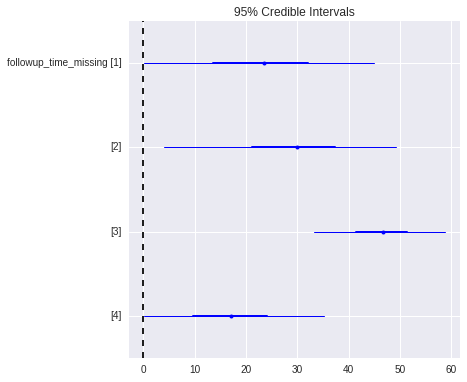

In [45]:
pm.forestplot(trace_uae, varnames=['followup_time_missing'])

Baseline estimates for each outcome, on the log scale.

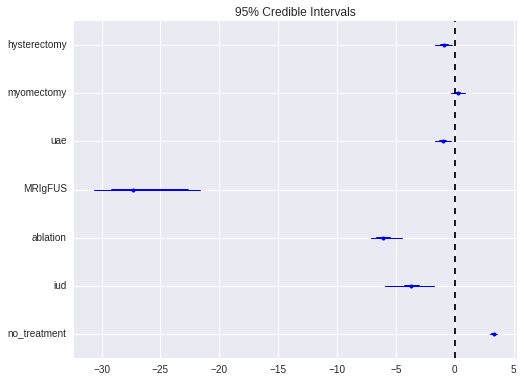

In [46]:
pm.forestplot(trace_uae, varnames=['μ'], ylabels=plot_labels)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd59b78d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fcd5d30ff60>]], dtype=object)

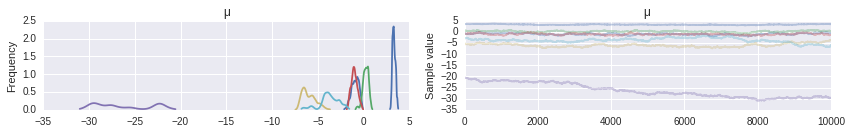

In [47]:
pm.traceplot(trace_uae, varnames=['μ'])

Follow-up time effect size estimates. Positive values indicate higher probability of event with increased follow-up time.

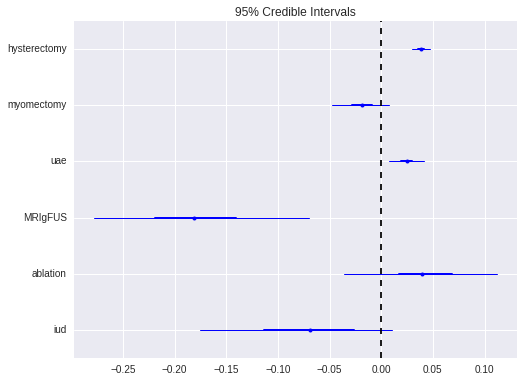

In [48]:
pm.forestplot(trace_uae, varnames=['θ_fup'], ylabels=plot_labels[:-1])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd54574438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fcd5442df28>]], dtype=object)

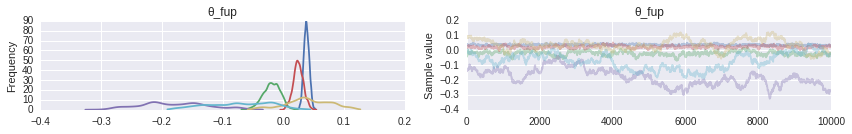

In [49]:
pm.traceplot(trace_uae, varnames=['θ_fup'])

Age effect size estimates. Positive values suggest higher probability of event with each year above age 40.

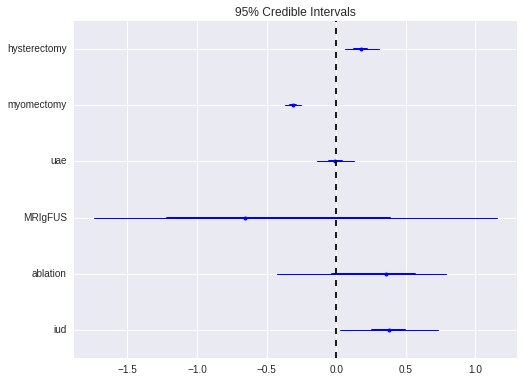

In [50]:
pm.forestplot(trace_uae, varnames=['θ_age'], ylabels=plot_labels[:-1])

Estimated probabilities of follow-up interventions for 6-month followup and age 40.

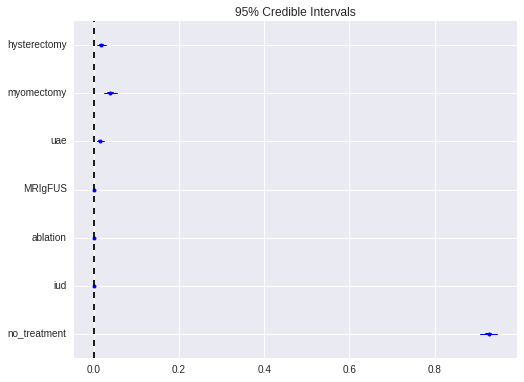

In [51]:
pm.forestplot(trace_uae, varnames=['p_6'], ylabels=plot_labels)

Estimates corresponding to the above (in the same order as plotted)

In [52]:
pm.summary(trace_uae, varnames=['p_6'])


p_6:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.018            0.005            0.000            [0.008, 0.027]
  0.039            0.008            0.001            [0.023, 0.053]
  0.015            0.005            0.000            [0.007, 0.023]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.001            0.001            0.000            [0.000, 0.002]
  0.928            0.010            0.001            [0.906, 0.947]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.008          0.014          0.017          0.022          0.028
  0.024          0.033          0.038          0.044          0.054
  0.008          0.012          0.014          0.018          0.025
  0.000     

Estimated probabilities of follow-up interventions for 12-month followup and age 40.

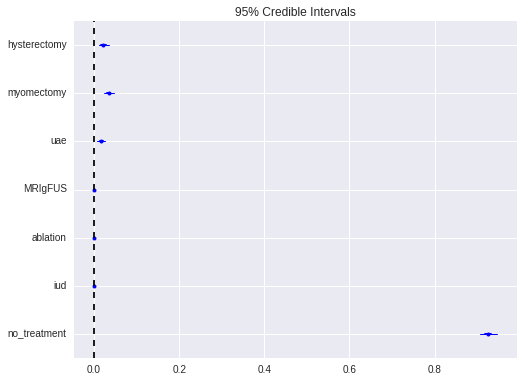

In [53]:
pm.forestplot(trace_uae, varnames=['p_12'], ylabels=plot_labels)

In [54]:
pm.summary(trace_uae, varnames=['p_12'])


p_12:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.022            0.006            0.001            [0.011, 0.034]
  0.034            0.006            0.000            [0.023, 0.046]
  0.017            0.005            0.000            [0.008, 0.026]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.001]
  0.926            0.010            0.001            [0.907, 0.947]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.011          0.017          0.022          0.027          0.034
  0.022          0.030          0.034          0.038          0.046
  0.009          0.014          0.017          0.020          0.027
  0.000    

Estimated probabilities of follow-up interventions for 24-month followup and age 40.

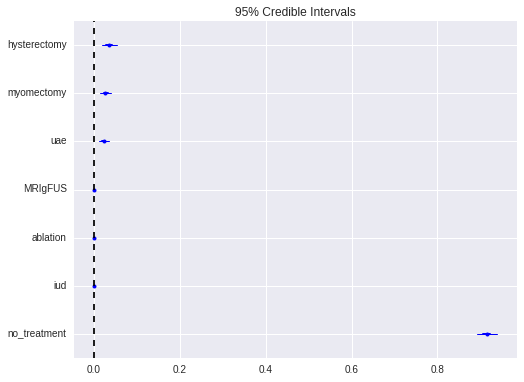

In [55]:
pm.forestplot(trace_uae, varnames=['p_24'], ylabels=plot_labels)

In [56]:
pm.summary(trace_uae, varnames=['p_24'])


p_24:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.035            0.009            0.001            [0.018, 0.052]
  0.027            0.006            0.000            [0.015, 0.039]
  0.023            0.006            0.000            [0.011, 0.034]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.001]
  0.000            0.000            0.000            [0.000, 0.001]
  0.915            0.012            0.001            [0.892, 0.939]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.018          0.028          0.034          0.042          0.053
  0.016          0.023          0.027          0.032          0.041
  0.012          0.019          0.022          0.026          0.036
  0.000    

Estimated probabilities of follow-up interventions for 6-month followup and age 30.

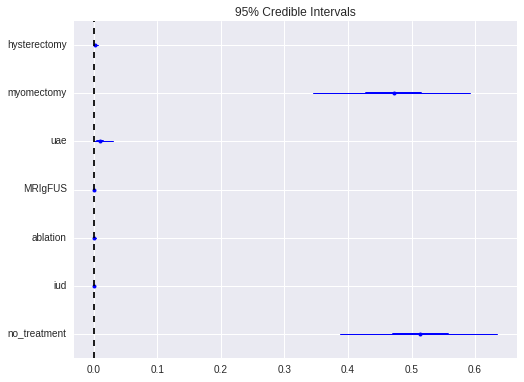

In [57]:
pm.forestplot(trace_uae, varnames=['p_6_30'], ylabels=plot_labels)

In [58]:
pm.summary(trace_uae, varnames=['p_6_30'])


p_6_30:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.002            0.002            0.000            [0.000, 0.006]
  0.472            0.064            0.003            [0.345, 0.593]
  0.011            0.009            0.001            [0.000, 0.030]
  0.000            0.000            0.000            [0.000, 0.000]
  0.001            0.002            0.000            [0.000, 0.004]
  0.000            0.001            0.000            [0.000, 0.001]
  0.514            0.063            0.003            [0.388, 0.635]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.001          0.002          0.003          0.008
  0.346          0.428          0.473          0.515          0.596
  0.001          0.005          0.009          0.015          0.036
  0.000  

Estimated probabilities of follow-up interventions for 6-month followup and age 50.

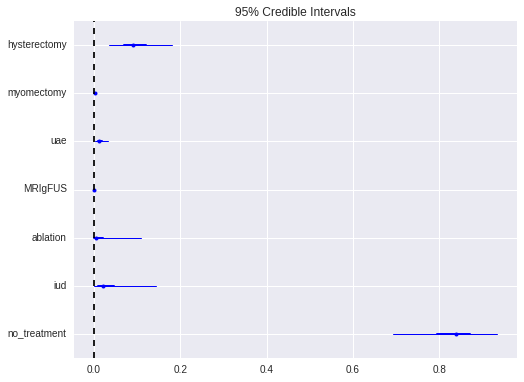

In [59]:
pm.forestplot(trace_uae, varnames=['p_6_50'], ylabels=plot_labels)

In [60]:
pm.summary(trace_uae, varnames=['p_6_50'])


p_6_50:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.098            0.040            0.003            [0.034, 0.180]
  0.002            0.001            0.000            [0.000, 0.003]
  0.015            0.011            0.001            [0.002, 0.033]
  0.000            0.000            0.000            [0.000, 0.000]
  0.022            0.042            0.004            [0.000, 0.109]
  0.039            0.054            0.004            [0.000, 0.144]
  0.825            0.068            0.005            [0.693, 0.934]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.040          0.069          0.091          0.120          0.194
  0.001          0.001          0.002          0.002          0.004
  0.004          0.008          0.012          0.018          0.043
  0.000  

Estimated probabilities of follow-up interventions for 24-month followup and age 30.

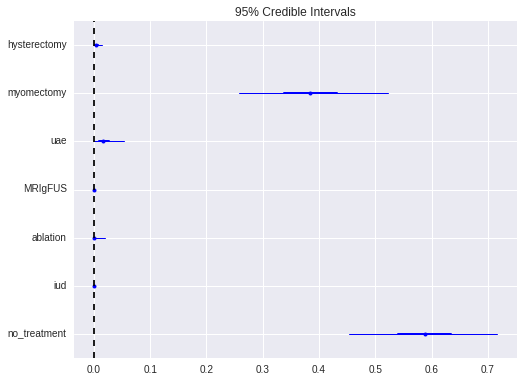

In [61]:
pm.forestplot(trace_uae, varnames=['p_24_30'], ylabels=plot_labels)

In [62]:
pm.summary(trace_uae, varnames=['p_24_30'])


p_24_30:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.005            0.005            0.000            [0.000, 0.015]
  0.385            0.068            0.004            [0.258, 0.523]
  0.020            0.016            0.001            [0.000, 0.054]
  0.000            0.000            0.000            [0.000, 0.000]
  0.003            0.009            0.001            [0.000, 0.020]
  0.000            0.000            0.000            [0.000, 0.000]
  0.587            0.068            0.004            [0.453, 0.717]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.002          0.004          0.007          0.018
  0.257          0.338          0.383          0.432          0.523
  0.002          0.008          0.016          0.027          0.064
  0.000 

Estimated probabilities of follow-up interventions for 24-month followup and age 50.

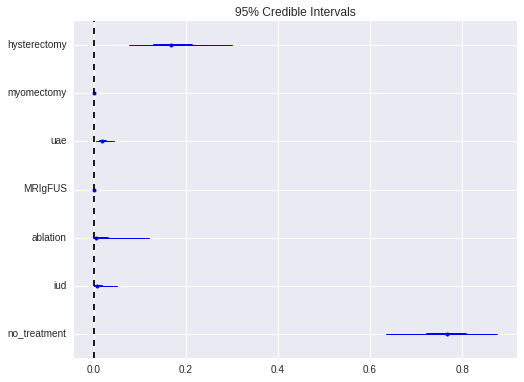

In [63]:
pm.forestplot(trace_uae, varnames=['p_24_50'], ylabels=plot_labels)

In [64]:
pm.summary(trace_uae, varnames=['p_24_50'])


p_24_50:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.177            0.062            0.005            [0.075, 0.300]
  0.001            0.001            0.000            [0.000, 0.002]
  0.021            0.014            0.001            [0.004, 0.043]
  0.000            0.000            0.000            [0.000, 0.000]
  0.025            0.041            0.003            [0.000, 0.120]
  0.013            0.020            0.002            [0.000, 0.049]
  0.763            0.063            0.005            [0.635, 0.876]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.083          0.131          0.168          0.213          0.318
  0.000          0.001          0.001          0.001          0.002
  0.007          0.012          0.018          0.025          0.053
  0.000 

In [94]:
tables = []

for scenario in uae_model.deterministics[1:]:
    
    table = pm.df_summary(trace_uae, varnames=[scenario]).round(3).drop('mc_error', axis=1)
    table.index = plot_labels.values.tolist()[:-1] + ['none']
    
    tokens = scenario.name.split('_')
    fup = int(tokens[1])
    if len(tokens)==3:
        age = int(tokens[2])
    else:
        age = 40
        
    table['age'] = age
    table['followup'] = fup
    table.index.name = 'next intervention'
    
    tables.append(table)

In [96]:
uae_table = (pd.concat(tables).set_index(['age', 'followup'], append=True)
                 .reorder_levels([1,2,0])
                 .sort_index(level='age'))

In [97]:
uae_table

mean     sd  hpd_2.5  hpd_97.5
age followup next intervention                                 
30  6        MRIgFUS            0.000  0.000    0.000     0.000
             ablation           0.001  0.002    0.000     0.004
             hysterectomy       0.002  0.002    0.000     0.006
             iud                0.000  0.001    0.000     0.001
             myomectomy         0.472  0.064    0.345     0.593
             none               0.514  0.063    0.388     0.635
             uae                0.011  0.009    0.000     0.030
    24       MRIgFUS            0.000  0.000    0.000     0.000
             ablation           0.003  0.009    0.000     0.020
             hysterectomy       0.005  0.005    0.000     0.015
             iud                0.000  0.000    0.000     0.000
             myomectomy         0.385  0.068    0.258     0.523
             none               0.587  0.068    0.453     0.717
             uae                0.020  0.016    0.000     0.054
40  6        MRIgFUS            0.000  0.000    0.000     0.000
             ablation           0.000  0.000    0.000     0.000
             hysterectomy       0.018  0.005    0.008     0.027
             iud                0.001  0.001    0.000     0.002
             myomectomy         0.039  0.008    0.023     0.053
             none               0.928  0.010    0.906     0.947
             uae                0.015  0.005    0.007     0.023
    12       MRIgFUS            0.000  0.000    0.000     0.000
             ablation           0.000  0.000    0.000     0.000
             hysterectomy       0.022  0.006    0.011     0.034
             iud                0.000  0.000    0.000     0.001
             myomectomy         0.034  0.006    0.023     0.046
             none               0.926  0.010    0.907     0.947
             uae                0.017  0.005    0.008     0.026
    24       MRIgFUS            0.000  0.000    0.000     0.000
             ablation           0.000  0.000    0.000     0.001
             hysterectomy       0.035  0.009    0.018     0.052
             iud                0.000  0.000    0.000     0.001
             myomectomy         0.027  0.006    0.015     0.039
             none               0.915  0.012    0.892     0.939
             uae                0.023  0.006    0.011     0.034
50  6        MRIgFUS            0.000  0.000    0.000     0.000
             ablation           0.022  0.042    0.000     0.109
             hysterectomy       0.098  0.040    0.034     0.180
             iud                0.039  0.054    0.000     0.144
             myomectomy         0.002  0.001    0.000     0.003
             none               0.825  0.068    0.693     0.934
             uae                0.015  0.011    0.002     0.033
    24       MRIgFUS            0.000  0.000    0.000     0.000
             ablation           0.025  0.041    0.000     0.120
             hysterectomy       0.177  0.062    0.075     0.300
             iud                0.013  0.020    0.000     0.049
             myomectomy         0.001  0.001    0.000     0.002
             none               0.763  0.063    0.635     0.876
             uae                0.021  0.014    0.004     0.043

### Myomectomy model

In [59]:
myomectomy_model = specify_model(pm.Model(), 'myomectomy')

Applied log-transform to σ and added transformed σ_log to model.


In [60]:
with myomectomy_model:
    
    if use_NUTS:
        
        trace_myomectomy = pm.sample(n_iterations/20, random_seed=20140925)
    
    else:
    
        trace_myomectomy = pm.sample(n_iterations, step=pm.Metropolis(),  
                                     random_seed=20140925)

 [-----------------100%-----------------] 50000 of 50000 complete in 11226.2 sec

Baseline estimates on log scale

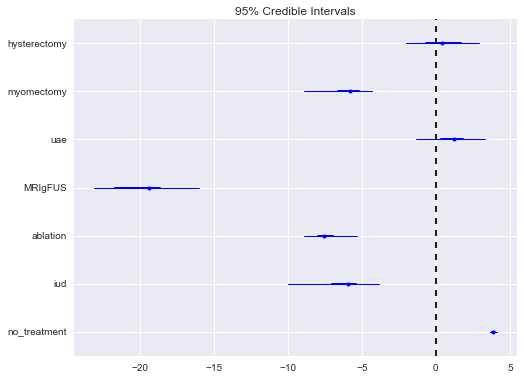

In [61]:
pm.forestplot(trace_myomectomy, varnames=['μ'], ylabels=plot_labels)

Followup time effect

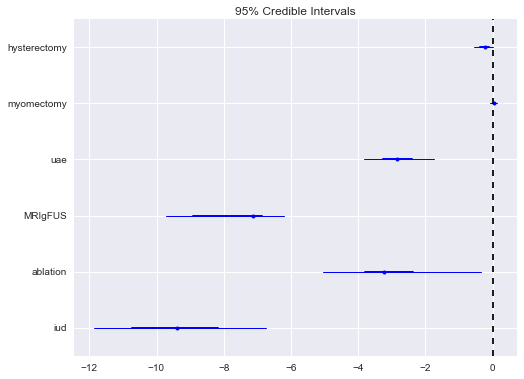

In [62]:
pm.forestplot(trace_myomectomy, varnames=['θ_fup'], ylabels=plot_labels[:-1])

Age over 40 effect

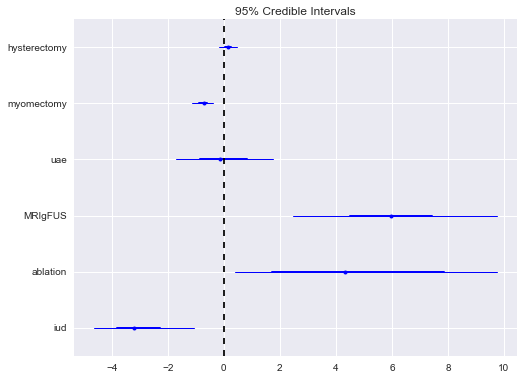

In [63]:
pm.forestplot(trace_myomectomy, varnames=['θ_age'], ylabels=plot_labels[:-1])

Predicted probabilities for 6 months after followup, 40 years of age.

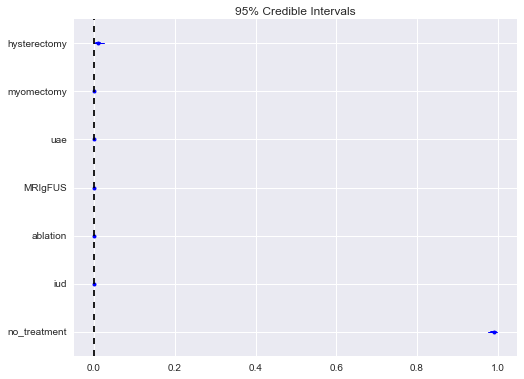

In [64]:
pm.forestplot(trace_myomectomy, varnames=['p_6'], ylabels=plot_labels)

In [65]:
pm.summary(trace_myomectomy, varnames=['p_6'])


p_6:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.011            0.007            0.001            [0.001, 0.025]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.989            0.007            0.001            [0.975, 0.999]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.002          0.005          0.009          0.015          0.028
  0.000          0.000          0.000          0.000          0.000
  0.000          0.000          0.000          0.000          0.000
  0.000     

Estimated probabilities of follow-up interventions for 12-month followup and age 40.

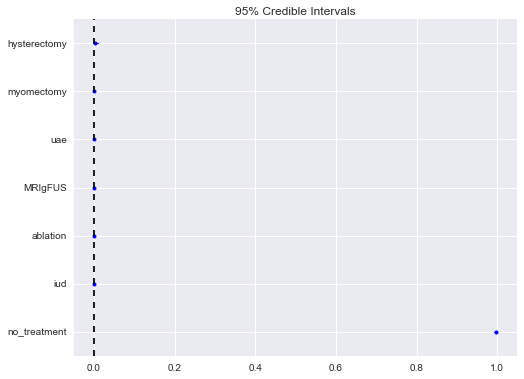

In [66]:
pm.forestplot(trace_myomectomy, varnames=['p_12'], ylabels=plot_labels)

In [67]:
pm.summary(trace_myomectomy, varnames=['p_12'])


p_12:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.003            0.003            0.000            [0.000, 0.009]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.997            0.003            0.000            [0.991, 1.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.001          0.002          0.004          0.011
  0.000          0.000          0.000          0.000          0.001
  0.000          0.000          0.000          0.000          0.000
  0.000    

Estimated probabilities of follow-up interventions for 24-month followup and age 40.

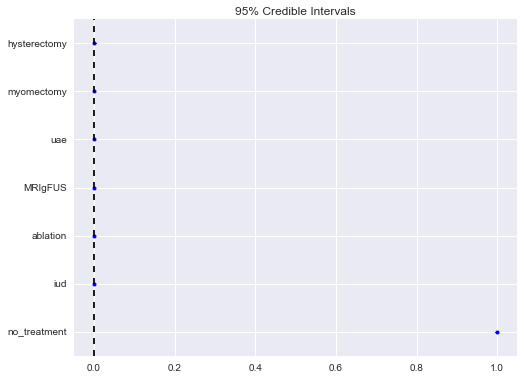

In [68]:
pm.forestplot(trace_myomectomy, varnames=['p_24'], ylabels=plot_labels)

In [69]:
pm.summary(trace_myomectomy, varnames=['p_24'])


p_24:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.001            0.002            0.000            [0.000, 0.005]
  0.000            0.001            0.000            [0.000, 0.001]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.999            0.002            0.000            [0.994, 1.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          0.000          0.001          0.007
  0.000          0.000          0.000          0.000          0.002
  0.000          0.000          0.000          0.000          0.000
  0.000    

Estimated probabilities of follow-up interventions for 6-month followup and age 30.

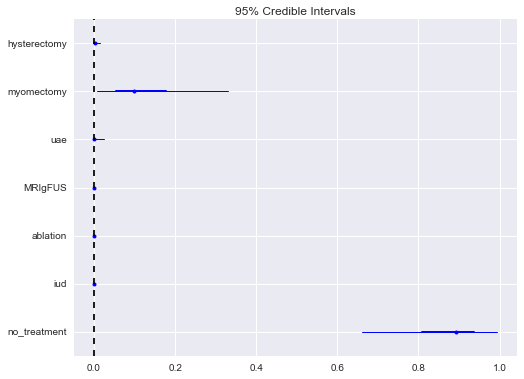

In [70]:
pm.forestplot(trace_myomectomy, varnames=['p_6_30'], ylabels=plot_labels)

In [71]:
pm.summary(trace_myomectomy, varnames=['p_6_30'])


p_6_30:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.004            0.007            0.000            [0.000, 0.014]
  0.128            0.098            0.008            [0.006, 0.330]
  0.005            0.025            0.002            [0.000, 0.025]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.863            0.099            0.008            [0.660, 0.995]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.001          0.002          0.005          0.023
  0.014          0.053          0.098          0.178          0.376
  0.000          0.000          0.000          0.000          0.072
  0.000  

Estimated probabilities of follow-up interventions for 6-month followup and age 50.

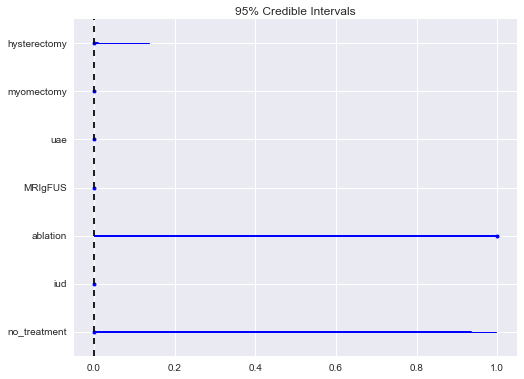

In [72]:
pm.forestplot(trace_myomectomy, varnames=['p_6_50'], ylabels=plot_labels)

In [73]:
pm.summary(trace_myomectomy, varnames=['p_6_50'])


p_6_50:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.022            0.068            0.004            [0.000, 0.137]
  0.000            0.000            0.000            [0.000, 0.000]
  0.018            0.125            0.012            [0.000, 0.000]
  0.008            0.076            0.005            [0.000, 0.000]
  0.613            0.475            0.047            [0.000, 1.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.338            0.446            0.044            [0.000, 0.996]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          0.000          0.009          0.229
  0.000          0.000          0.000          0.000          0.000
  0.000          0.000          0.000          0.000          0.091
  0.000  

Estimated probabilities of follow-up interventions for 24-month followup and age 30.

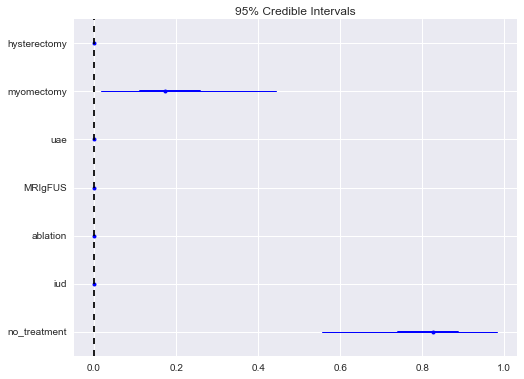

In [74]:
pm.forestplot(trace_myomectomy, varnames=['p_24_30'], ylabels=plot_labels)

In [75]:
pm.summary(trace_myomectomy, varnames=['p_24_30'])


p_24_30:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.000            0.001            0.000            [0.000, 0.002]
  0.199            0.121            0.010            [0.017, 0.445]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.800            0.120            0.010            [0.555, 0.983]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          0.000          0.000          0.003
  0.041          0.113          0.173          0.258          0.528
  0.000          0.000          0.000          0.000          0.000
  0.000 

Estimated probabilities of follow-up interventions for 24-month followup and age 50.

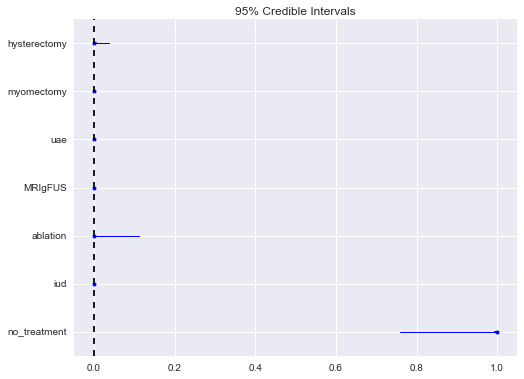

In [76]:
pm.forestplot(trace_myomectomy, varnames=['p_24_50'], ylabels=plot_labels)

In [77]:
pm.summary(trace_myomectomy, varnames=['p_24_50'])


p_24_50:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.008            0.029            0.002            [0.000, 0.036]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.037            0.173            0.015            [0.000, 0.112]
  0.000            0.000            0.000            [0.000, 0.000]
  0.954            0.173            0.015            [0.759, 1.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          0.001          0.004          0.081
  0.000          0.000          0.000          0.000          0.000
  0.000          0.000          0.000          0.000          0.000
  0.000 

### Medical management model

In [82]:
med_manage_model = specify_model(pm.Model(), 'med_manage')

Applied log-transform to nu and added transformed nu_log to model.
Applied log-transform to σ and added transformed σ_log to model.


In [83]:
with med_manage_model:
    
    if use_NUTS:
        
        trace_med_manage = pm.sample(n_iterations/20, random_seed=20140925)
        
    else:
        
        trace_med_manage = pm.sample(n_iterations, step=pm.Metropolis(),  
                                     random_seed=20140925)

 [-----------------100%-----------------] 50000 of 50000 complete in 699.0 sec

Baseline log-probabilities

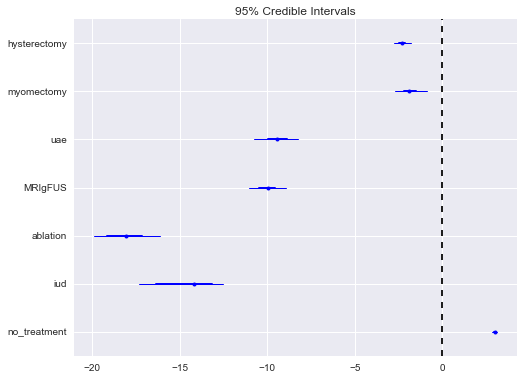

In [84]:
pm.forestplot(trace_med_manage, varnames=['μ'], ylabels=plot_labels)

Estimated probabilities of follow-up interventions for 6-month followup and age 40.

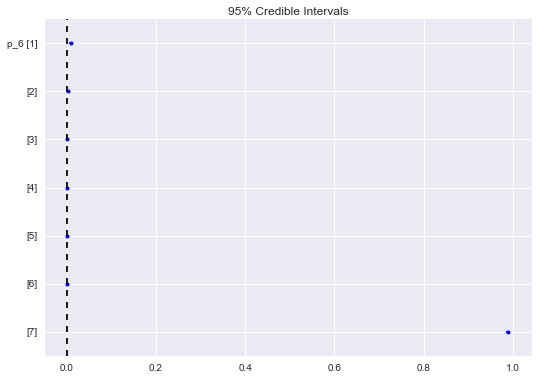

In [85]:
pm.forestplot(trace_med_manage, varnames=['p_6'])

In [86]:
pm.summary(trace_med_manage, varnames=['p_6'])


p_6:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.009            0.002            0.000            [0.005, 0.012]
  0.003            0.001            0.000            [0.001, 0.005]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.989            0.002            0.000            [0.985, 0.992]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.006          0.007          0.008          0.010          0.013
  0.001          0.002          0.003          0.003          0.005
  0.000          0.000          0.000          0.000          0.000
  0.000     

Estimated probabilities of follow-up interventions for 12-month followup and age 40.

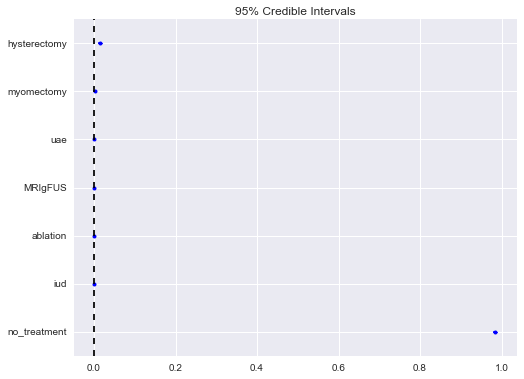

In [87]:
pm.forestplot(trace_med_manage, varnames=['p_12'], ylabels=plot_labels)

In [88]:
pm.summary(trace_med_manage, varnames=['p_12'])


p_12:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.014            0.003            0.000            [0.010, 0.020]
  0.001            0.001            0.000            [0.000, 0.003]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.984            0.003            0.000            [0.979, 0.990]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.010          0.013          0.014          0.016          0.020
  0.000          0.001          0.001          0.002          0.003
  0.000          0.000          0.000          0.000          0.000
  0.000    

Estimated probabilities of follow-up interventions for 24-month followup and age 40.

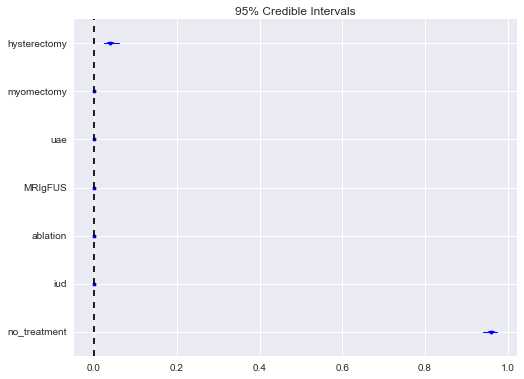

In [89]:
pm.forestplot(trace_med_manage, varnames=['p_24'], ylabels=plot_labels)

In [90]:
pm.summary(trace_med_manage, varnames=['p_24'])


p_24:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.041            0.009            0.001            [0.025, 0.059]
  0.000            0.001            0.000            [0.000, 0.002]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.959            0.009            0.001            [0.940, 0.974]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.027          0.034          0.039          0.045          0.062
  0.000          0.000          0.000          0.000          0.002
  0.000          0.000          0.000          0.000          0.000
  0.000    

Estimated probabilities of follow-up interventions for 6-month followup and age 30.

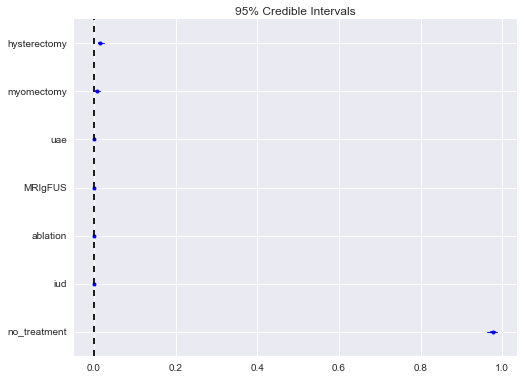

In [91]:
pm.forestplot(trace_med_manage, varnames=['p_6_30'], ylabels=plot_labels)

In [92]:
pm.summary(trace_med_manage, varnames=['p_6_30'])


p_6_30:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.016            0.004            0.000            [0.008, 0.025]
  0.007            0.004            0.000            [0.002, 0.015]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.977            0.007            0.001            [0.963, 0.988]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.009          0.012          0.015          0.018          0.026
  0.002          0.005          0.007          0.009          0.017
  0.000          0.000          0.000          0.000          0.000
  0.000  

Estimated probabilities of follow-up interventions for 6-month followup and age 50.

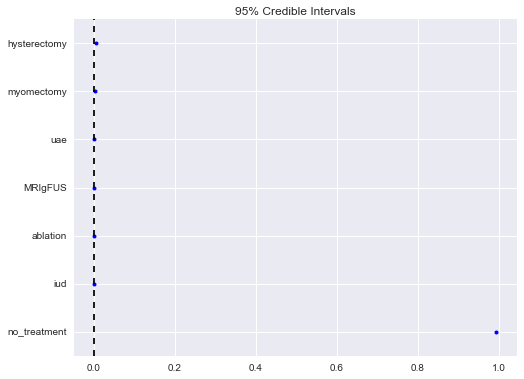

In [93]:
pm.forestplot(trace_med_manage, varnames=['p_6_50'], ylabels=plot_labels)

In [94]:
pm.summary(trace_med_manage, varnames=['p_6_50'])


p_6_50:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.005            0.002            0.000            [0.002, 0.008]
  0.001            0.001            0.000            [0.000, 0.002]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.994            0.002            0.000            [0.990, 0.997]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.002          0.004          0.005          0.006          0.008
  0.000          0.001          0.001          0.002          0.002
  0.000          0.000          0.000          0.000          0.000
  0.000  

Estimated probabilities of follow-up interventions for 24-month followup and age 30.

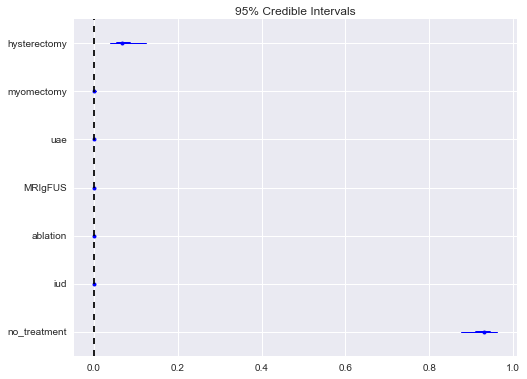

In [95]:
pm.forestplot(trace_med_manage, varnames=['p_24_30'], ylabels=plot_labels)

In [96]:
pm.summary(trace_med_manage, varnames=['p_24_30'])


p_24_30:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.073            0.024            0.002            [0.037, 0.123]
  0.001            0.002            0.000            [0.000, 0.004]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.926            0.025            0.002            [0.875, 0.963]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.041          0.055          0.067          0.086          0.134
  0.000          0.000          0.000          0.001          0.006
  0.000          0.000          0.000          0.000          0.000
  0.000 

Estimated probabilities of follow-up interventions for 24-month followup and age 50.

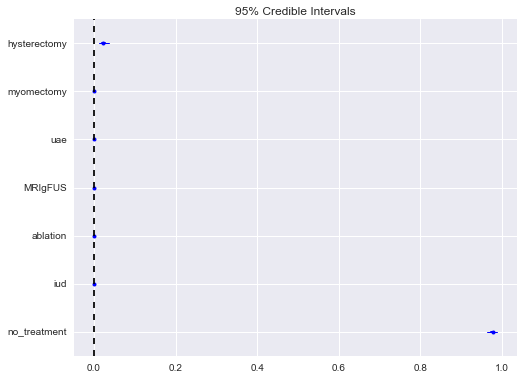

In [97]:
pm.forestplot(trace_med_manage, varnames=['p_24_50'], ylabels=plot_labels)

In [98]:
pm.summary(trace_med_manage, varnames=['p_24_50'])


p_24_50:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.023            0.006            0.000            [0.011, 0.036]
  0.000            0.000            0.000            [0.000, 0.001]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.977            0.006            0.000            [0.964, 0.989]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.012          0.019          0.023          0.027          0.038
  0.000          0.000          0.000          0.000          0.001
  0.000          0.000          0.000          0.000          0.000
  0.000 

## Model checking

Posterior predictive checks for models. We generate simulated datasets using the model, and check where the observed data lies in the distribution of simulated values. Extreme values of the data percentile is suggestive of problems.

In [100]:
ppc_uae = pm.sample_ppc(trace_uae, model=uae_model, samples=500)

In [104]:
intervention_data = dataset[(dataset.intervention_cat=='uae')
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)].copy()
    
outcomes = intervention_data[[ 'hysterectomy', 'myomectomy', 'uae',
       'MRIgFUS', 'ablation', 'iud', 'no_treatment']].values

In [116]:
from scipy.stats import percentileofscore

Calculate percentiles of each observation relative to simulated data.

In [138]:
percentiles = []

for label in ppc_uae:
    
    if label.startswith('likelihood'):
        
        tokens = label.split('_')
        index = int(tokens[1])
        
        simvals = ppc_uae[label]
        obsvals = outcomes[index]
        
        p = [percentileofscore(s, o).round(2) for s,o in zip(simvals.T, obsvals)]
        
        percentiles.append(pd.Series(p, index=plot_labels))
        
pd.concat(percentiles, axis=1).T

,hysterectomy,myomectomy,uae,MRIgFUS,ablation,iud,no_treatment
0,34.2,34.4,27.6,49.6,48.9,49.0,47.8
1,21.4,27.1,31.6,49.8,49.1,48.9,70.1
2,56.6,99.2,95.9,49.4,49.2,48.4,25.1
3,12.9,28.4,28.5,49.4,49.0,47.3,63.3
4,31.5,42.5,41.3,49.6,49.4,48.7,38.4
5,16.2,44.7,98.1,49.6,47.9,46.8,32.6
6,95.1,66.0,20.8,49.0,45.7,43.2,77.4
7,63.3,26.3,15.5,49.2,46.7,45.4,80.0
8,36.7,0.2,22.5,49.3,49.0,49.0,37.1
9,93.8,19.8,98.6,49.5,46.1,45.1,69.0
